# Using TensorFlow Serving on SageMaker

TensorFlow Serving (**"TFS"**) is a native model server for TensorFlow 1, TensorFlow 2, and Keras models. It is designed to provide a flexible and high-performance runtime environment with an extensive management API and operational features (such as logging and metrics). AWS provides TFS as part of TensorFlow [inference containers](https://github.com/aws/deep-learning-containers/tree/master/tensorflow/inference/docker).

In this example, we will take one of the pre-trained models from TensorFlow Hub, convert it into SavedModel format, and then package it with the custom inference for deployment on SageMaker. We will review how we can use both the REST and gRPC APIs and how to define the TFS configuration when it’s deployed on SageMaker Managed Hosting. For this task, we will use the popular `EfficientNetV2` model architecture to classify images.

### Preparing Model

We will start by loading the model artifacts from TensorFlow Hub. You can read about the EfficientNetV2 model on its model page [here](https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2). To download the model, we can use the TensorFlow Hub API, as shown in the following code block:

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"
classifier = hub.load(model_handle)

To test the model locally, you need to convert the image (or a batch of images) into the expected 4D tensor, run it through the model, and apply the softmax function to get the label probabilities, as shown here:

In [ ]:
input_shape = [1, 384, 384, 3]
image = tf.random.uniform(input_shape, 0, 1.0)
probabilities = tf.nn.softmax(classifier(image)).numpy()

### Packaging Model Artifacts

TFS expects your model to be converted into SavedModel format. Additionally, SageMaker expects the model artifact to be packaged into a tar.gz archive with the following structure:

```python
    model1
        |--[model_version_number]
            |--variables
            |--saved_model.pb
    model2
        |--[model_version_number]
            |--assets
            |--variables
            |--saved_model.pb
    code
        |--inference.py
        |--requirements.txt
```

The following code creates the appropriate directory structure and exports the trained model in SavedModel format:

In [ ]:
import os

model_name = "efficientnetv2-s"
model_dir = f"./{model_name}/1"
code_dir = f"./{model_name}/code"
os.makedirs(model_dir, exist_ok=False)
os.makedirs(code_dir, exist_ok=False)
tf.saved_model.save(classifier, model_dir)

Note that in our example, we will only use a single version of a single model. Next, we need to prepare an inference script for preprocessing, running predictions, and postprocessing between the SageMaker HTTP frontend and the TFS server.


### Developing Inference Script

SageMaker expects your processing code to be named `inference.py` and placed in the `/code` directory in the model archive. Let's review key aspects of inference script:
1. Inference code needs to implement either the `input_handler()` and `output_handler()` functions or a single `handler()` function. In our case, we have chosen to implement a single `handler()` method to process incoming requests and send it to the appropriate TFS API:
```python
    def handler(data, context):

        if context.request_content_type == "application/json":
            instance = json.loads(data.read().decode("utf-8"))
        else:
            raise ValueError(
                415,
                'Unsupported content type "{}"'.format(
                    context.request_content_type or "Unknown"
                ),
            )

        if USE_GRPC:
            prediction = _predict_using_grpc(context, instance)
        else:
            inst_json = json.dumps({"instances": instance})
            response = requests.post(context.rest_uri, data=inst_json)
            if response.status_code != 200:
                raise Exception(response.content.decode("utf-8"))
            res = response.content
            request_size = sys.getsizeof(inst_json)
            response_size = sys.getsizeof(res)
            print("request payload size")
            print(request_size)
            print("response payload size")
            print(response_size)
            prediction = res

        response_content_type = context.accept_header
        return prediction, response_content_type
```
2. As you can see, depending on whether we want to use the gRCP API or the REST API, the processing and prediction code will be slightly different. Note that the context namedtuple object provides necessary details about the TFS configuration, such as the endpoint path and ports, model name and version, and more. If we choose to use the TFS REST API, we need to convert the incoming request into the expected TFS format, serialize it into JSON, and then generate a POST request. To use the gRPC API, we will need to convert the incoming REST payload into a protobuf object. For this, we will use the following helper function:
```python
    def _predict_using_grpc(context, instance):
        grpc_request = predict_pb2.PredictRequest()
        grpc_request.model_spec.name = "model"
        grpc_request.model_spec.signature_name = "serving_default"

        options = [
            ("grpc.max_send_message_length", MAX_GRPC_MESSAGE_LENGTH),
            ("grpc.max_receive_message_length", MAX_GRPC_MESSAGE_LENGTH),
        ]

        channel = grpc.insecure_channel(f"0.0.0.0:{context.grpc_port}", options=options)
        stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

        grpc_request.inputs["input_1"].CopyFrom(tf.make_tensor_proto(instance))
        result = stub.Predict(grpc_request, 10)
        output_shape = [dim.size for dim in result.outputs["output_1"].tensor_shape.dim]
        print(f"output shape: {output_shape}")
        np_result = np.array(result.outputs["output_1"].float_val).reshape(output_shape)
        return json.dumps({"predictions": np_result.tolist()})
```
3. To choose what TFS API to call, we implemented a simple mechanism that allows you to provide the USE_GRPC environment variable via a SageMaker Model object:
```python
    USE_GRPC = True if os.getenv("USE_GRPC").lower() == "true" else
    False
```
Feel free to review full code listing by running cell below:

In [ ]:
! pygmentize 1_src/inference.py

4. Once we have our inference.py code ready, we can add it to the model package and create a tar. gz model archive. This can be done by running the following Bash code from a Jupyter notebook:

In [ ]:
! cp 1_src/inference.py $code_dir
! cp 1_src/requirements.txt $code_dir
!tar -C "$PWD" -czf model.tar.gz  efficientnetv2-s/

## Deploying TFS Model

To deploy the TFS model, follow these steps:
1. We will start by uploading our model archive to Amazon S3 so that SageMaker can download it to the serving container at deployment time. We can use a SageMaker `Session()` object to do this:

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlowModel

sagemaker_session = sagemaker.Session()
role = get_execution_role() 


bucket = sagemaker_session.default_bucket()
prefix = 'tf-serving'
s3_path = 's3://{}/{}'.format(bucket, prefix)


model_data = sagemaker_session.upload_data('model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))

2. Then, we can use the SageMaker SDK `TensorFlowModel` object to configure the TFS environment. Note that we are providing the TFS configuration via the `env` dictionary.

In [ ]:
env = {"SAGEMAKER_GUNICORN_LOGLEVEL":"debug",
       "SAGEMAKER_TFS_ENABLE_BATCHING":"true",
       "SAGEMAKER_TFS_MAX_BATCH_SIZE":"4",
       "SAGEMAKER_TFS_BATCH_TIMEOUT_MICROS":"100000",
       "SAGEMAKER_TFS_NUM_BATCH_THREADS":"6",
       "SAGEMAKER_TFS_MAX_ENQUEUED_BATCHES":"6",
       "USE_GRPC":"true" # set to False to use HTTPS API
       }

tensorflow_serving_model = TensorFlowModel(model_data=model_data,
                                 name="efficientnetv2-1",
                                 role=role,
                                 framework_version='2.8',
                                 env=env,
                                 sagemaker_session=sagemaker_session)

3. Once the model has been configured, we are ready to deploy the endpoint. Here, we will use one of the GPU instances, but you can experiment with CPU instances as well.

In [ ]:
predictor = tensorflow_serving_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

## Test TFS Endpoint

Now, let's test our newly created TFS endpoint. 

1. Before we can run predictions, we need to convert the image (or several images) into a 4D TFS tensor and then convert it into a NumPy ndarray that the `.predict()` method knows how to serialize into the application/JSON content type. Run cells below to fetch labels from `ImageNet` dataset and preprocess sample image with bus.


In [ ]:
labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

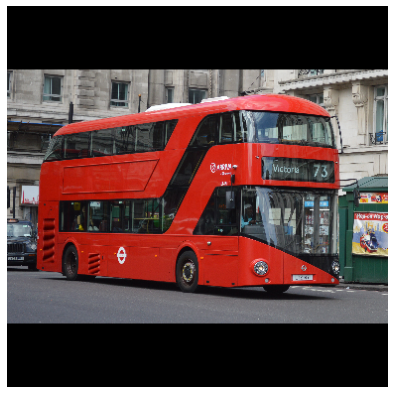

In [17]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def preprocess_image(image):
    image = np.array(image)
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    return image


def load_image(image_url, image_size=384):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(image_url, headers=user_agent)
    image = Image.open(BytesIO(response.content))
    image = preprocess_image(image)
    image = tf.image.resize_with_pad(image, image_size, image_size)

    if len(image.shape) == 3:
        image = tf.stack([image, image, image], axis=-1)    
    return image

def show_image(image, title=''):
    image_size = image.shape[1]
    w = (image_size * 6) // 320
    plt.figure(figsize=(w, w))
    plt.imshow(image[0], aspect='equal')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Sample image with double deck bus
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg"

image = load_image(image_url, image_size=384)
show_image(image=image)

2. Now, we are ready to send inference payload to our endpoint and check output predictions. Run cells below for this.

In [ ]:
response_remote = predictor.predict(image.numpy())

In [ ]:
probabilities = np.array(response_remote['predictions'])

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)


### Resource Cleanup

Execute cell below to delete endpoints and model artifact:

In [ ]:
predictor.delete_endpoint(delete_endpoint_config=True)
tensorflow_serving_model.delete_model()